In [26]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from shapely.geometry import LineString
from datashader.bundling import hammer_bundle
from mapclassify import NaturalBreaks
from pyproj import CRS

china_crs = CRS.from_proj4(
    "+proj=aea +lat_1=25 +lat_2=47 +lat_0=0 +lon_0=105 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs"
)

from plot_scale import plotscale

## 数据准备

In [27]:
def bundle_od(airports: pd.DataFrame, flights: pd.DataFrame, crs: str="EPSG:4326", 
              decay: float=0.7, initial_bandwidth: float=0.05, tension: float=0.3):
    
    airports_gdf = gpd.GeoDataFrame(
        airports,
        geometry=gpd.points_from_xy(airports["longitude"], airports["latitude"]),
        crs=crs
    )
    nodes_df = airports_gdf.set_index("iata")[["geometry"]].rename(columns={"geometry": "point"})
    nodes_df["x"] = nodes_df.point.x
    nodes_df["y"] = nodes_df.point.y
    
    edges_df = flights.merge(nodes_df[["x", "y"]].rename(columns={"x": "source_x", "y": "source_y"}), 
                             left_on="origin", right_index=True) \
                      .merge(nodes_df[["x", "y"]].rename(columns={"x": "target_x", "y": "target_y"}), 
                             left_on="destination", right_index=True)
                             
    edges_to_bundle = edges_df[["origin", "destination"]].rename(
        columns={"origin": "source", "destination": "target"}
    ).astype(str)
    bundled_coords = hammer_bundle(
        nodes_df,
        edges_to_bundle,
        decay=decay,  # 0~1；控制带宽随迭代过程的衰减速度，值越小衰减越快
        initial_bandwidth=initial_bandwidth,  # >0.0；控制算法初始阶段对邻近边的"感知范围"，值越大，更多邻近边会被纳入同一组进行聚集
        tension=tension,  # >=0；指数平滑因子，控制路径弯曲的程度，值越大线条弯曲越明显
    )
    bundled_df = pd.DataFrame(bundled_coords, columns=["x", "y"])

    line_ids = bundled_df['x'].isnull().cumsum()
    bundled_df['line_id'] = line_ids
    bundled_df.dropna(subset=['x', 'y'], inplace=True)
    bundled_gdf = gpd.GeoDataFrame(
        geometry=bundled_df.groupby('line_id').apply(
            lambda x: LineString(zip(x['x'], x['y'])),
            include_groups=False
        ),
        crs=crs
    )

    bundled_gdf.reset_index(inplace=True)
    bundled_gdf['FID'] = edges_df['FID'].iloc[bundled_gdf['line_id']].values
    final_gdf = bundled_gdf.merge(flights, on="FID", how="left").drop(columns='line_id')
    
    return final_gdf

In [28]:
airports = pd.read_csv("data/airports.csv", dtype={"iata": str})
flights = pd.read_csv("data/flights.csv", dtype={"origin": str, "destination": str})
flights["FID"] = flights.index

In [29]:
airports

,iata,name,city,state,country,latitude,longitude
0,OYB,阿克苏机场,阿克苏,新疆维吾尔自治区,中国,41.188341,80.293842
1,ICP,阿勒泰机场,阿勒泰,新疆维吾尔自治区,中国,47.890136,87.926214
2,SAG,天柱山机场,安庆,安徽省,中国,30.537898,117.058739
3,DAD,二里半机场,包头,内蒙古自治区,中国,40.647119,109.846238
4,NFO,保山机场,保山,云南省,中国,25.120489,99.177996
...,...,...,...,...,...,...,...
209,SSU,库车机场,库车,新疆维吾尔自治区,中国,41.781933,83.459807
210,ZKD,T3中川机场,兰州,甘肃省,中国,36.064226,103.823305
211,TMZ,那拉提机场,那拉提,新疆维吾尔自治区,中国,43.334690,84.010300
212,RDF,T3流亭机场,青岛,山东省,中国,36.105215,120.384428


In [30]:
flights

,origin,destination,count,FID
0,GVS,MLR,1,0
1,GVS,JTL,1,1
2,GVS,PZE,1,2
3,GVS,OTY,11,3
4,GVS,DJG,1,4
...,...,...,...,...
3192,CRF,CJZ,1,3192
3193,CRF,LAK,11,3193
3194,CRF,ECD,1,3194
3195,CRF,GUK,2,3195


In [31]:
bundled_od_gdf = bundle_od(
    airports,
    flights,
    decay=0.1,
    initial_bandwidth=1,
    tension=0.5
)
bundled_od_gdf

,geometry,FID,origin,destination,count
0,"LINESTRING (100.22963 26.87535, 100.74983 26.8...",0,GVS,MLR,1
1,"LINESTRING (100.22963 26.87535, 100.64813 26.8...",1,GVS,JTL,1
2,"LINESTRING (100.22963 26.87535, 100.72826 26.8...",2,GVS,PZE,1
3,"LINESTRING (100.22963 26.87535, 100.75882 26.8...",3,GVS,OTY,11
4,"LINESTRING (100.22963 26.87535, 100.66891 26.8...",4,GVS,DJG,1
...,...,...,...,...,...
3192,"LINESTRING (120.69064 28.00284, 120.31704 28.1...",3192,CRF,CJZ,1
3193,"LINESTRING (120.69064 28.00284, 120.29888 28.1...",3193,CRF,LAK,11
3194,"LINESTRING (120.69064 28.00284, 120.32827 28.1...",3194,CRF,ECD,1
3195,"LINESTRING (120.69064 28.00284, 120.30014 28.1...",3195,CRF,GUK,2


In [ ]:
# bundled_od_gdf.to_file('data/od.shp', index=False)

C:\Users\15499\AppData\Local\Temp\ipykernel_31060\2589176139.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  bundled_od_gdf.to_file('data/od.shp', index=False)
d:\Anaconda3\envs\py311\Lib\site-packages\pyogrio\raw.py:723: RuntimeWarning: Normalized/laundered field name: 'destination' to 'destinatio'
  ogr_write(


In [8]:
china = gpd.read_file("data/T2024年初省级.shp")
nine_lines = gpd.read_file("data/十段线.shp")
coastline = gpd.read_file("data/海岸线.shp")
land_boundary = gpd.read_file("data/陆地边界.shp")

In [9]:
china_proj = china.to_crs(china_crs)
nine_lines_proj = nine_lines.to_crs(china_crs)
coastline_proj = coastline.to_crs(china_crs)
land_boundary_proj = land_boundary.to_crs(china_crs)

bundled_od_gdf_proj = bundled_od_gdf.to_crs(china_crs)

## 计算节点度

In [10]:
out_degree = {}
in_degree = {}

# 遍历每一行
for _, row in flights.iterrows():
    org = row['origin']
    dst = row['destination']
    cnt = row['count']

    out_degree[org] = out_degree.get(org, 0) + cnt
    in_degree[dst] = in_degree.get(dst, 0) + cnt

# 合并所有节点
all_nodes = set(out_degree.keys()) | set(in_degree.keys())

# 构建结果
degree_data = []
for node in all_nodes:
    out_deg = out_degree.get(node, 0)
    in_deg = in_degree.get(node, 0)
    total_deg = out_deg + in_deg
    degree_data.append({
        'node': node,
        'out_degree': out_deg,
        'in_degree': in_deg,
        'total_degree': total_deg
    })
degree_df = pd.DataFrame(degree_data)

In [11]:
nb = NaturalBreaks(degree_df['total_degree'], k=4)
degree_df['degree_level'] = nb.yb

levels = []
for i in range(4):
    if i == 0:
        level_range = f"{degree_df['total_degree'].min():.2f} - {nb.bins[i]:.2f}"
    elif i == 3:
        level_range = f"{nb.bins[i-1]:.2f} - {degree_df['total_degree'].max():.2f}"
    else:
        level_range = f"{nb.bins[i-1]:.2f} - {nb.bins[i]:.2f}"
    levels.append(level_range)
degree_df['degree_level_range'] = degree_df['degree_level'].apply(lambda x: levels[x])

airports = airports.merge(degree_df.rename(columns={'node':'iata'})[['iata','total_degree','degree_level','degree_level_range']], on='iata', how='left')
airports

d:\Anaconda3\envs\py311\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


,iata,name,city,state,country,latitude,longitude,total_degree,degree_level,degree_level_range
0,OYB,阿克苏机场,阿克苏,新疆维吾尔自治区,中国,41.188341,80.293842,49,0,1.00 - 131.00
1,ICP,阿勒泰机场,阿勒泰,新疆维吾尔自治区,中国,47.890136,87.926214,6,0,1.00 - 131.00
2,SAG,天柱山机场,安庆,安徽省,中国,30.537898,117.058739,14,0,1.00 - 131.00
3,DAD,二里半机场,包头,内蒙古自治区,中国,40.647119,109.846238,116,0,1.00 - 131.00
4,NFO,保山机场,保山,云南省,中国,25.120489,99.177996,19,0,1.00 - 131.00
...,...,...,...,...,...,...,...,...,...,...
209,SSU,库车机场,库车,新疆维吾尔自治区,中国,41.781933,83.459807,2,0,1.00 - 131.00
210,ZKD,T3中川机场,兰州,甘肃省,中国,36.064226,103.823305,2,0,1.00 - 131.00
211,TMZ,那拉提机场,那拉提,新疆维吾尔自治区,中国,43.334690,84.010300,4,0,1.00 - 131.00
212,RDF,T3流亭机场,青岛,山东省,中国,36.105215,120.384428,1,0,1.00 - 131.00


In [12]:
airports.degree_level_range.unique()

array(['1.00 - 131.00', '788.00 - 1835.00', '131.00 - 406.00',
       '406.00 - 788.00'], dtype=object)

## 获取中间矢量数据

In [13]:
airports_gdf = gpd.GeoDataFrame(airports, geometry=gpd.points_from_xy(airports.longitude, airports.latitude), crs=4326)
airports_gdf_proj = airports_gdf.to_crs(china_crs)

In [14]:
china_proj1 = china_proj.query("`省` != '海南省' and `省` != '台湾省'").copy()
china_proj2 = china_proj.query("`省` == '海南省' or `省` == '台湾省'").copy()

In [15]:
nine_lines_buffer1_proj = gpd.GeoDataFrame(
    nine_lines_proj.drop(columns=['geometry']),
    geometry=nine_lines_proj.geometry.buffer(-20000, single_sided=True),
    crs=china_crs
)
nine_lines_buffer2_proj = gpd.GeoDataFrame(
    nine_lines_proj.drop(columns=['geometry']),
    geometry=nine_lines_proj.geometry.buffer(-40000, single_sided=True),
    crs=china_crs
)

land_boundary_buffer1_proj = gpd.GeoDataFrame(
    land_boundary_proj.drop(columns=['geometry']),
    geometry=land_boundary_proj.geometry.buffer(20000, single_sided=True),
    crs=china_crs
)
land_boundary_buffer2_proj = gpd.GeoDataFrame(
    land_boundary_proj.drop(columns=['geometry']),
    geometry=land_boundary_proj.geometry.buffer(40000, single_sided=True),
    crs=china_crs
)

## 制图

### 国家矢量

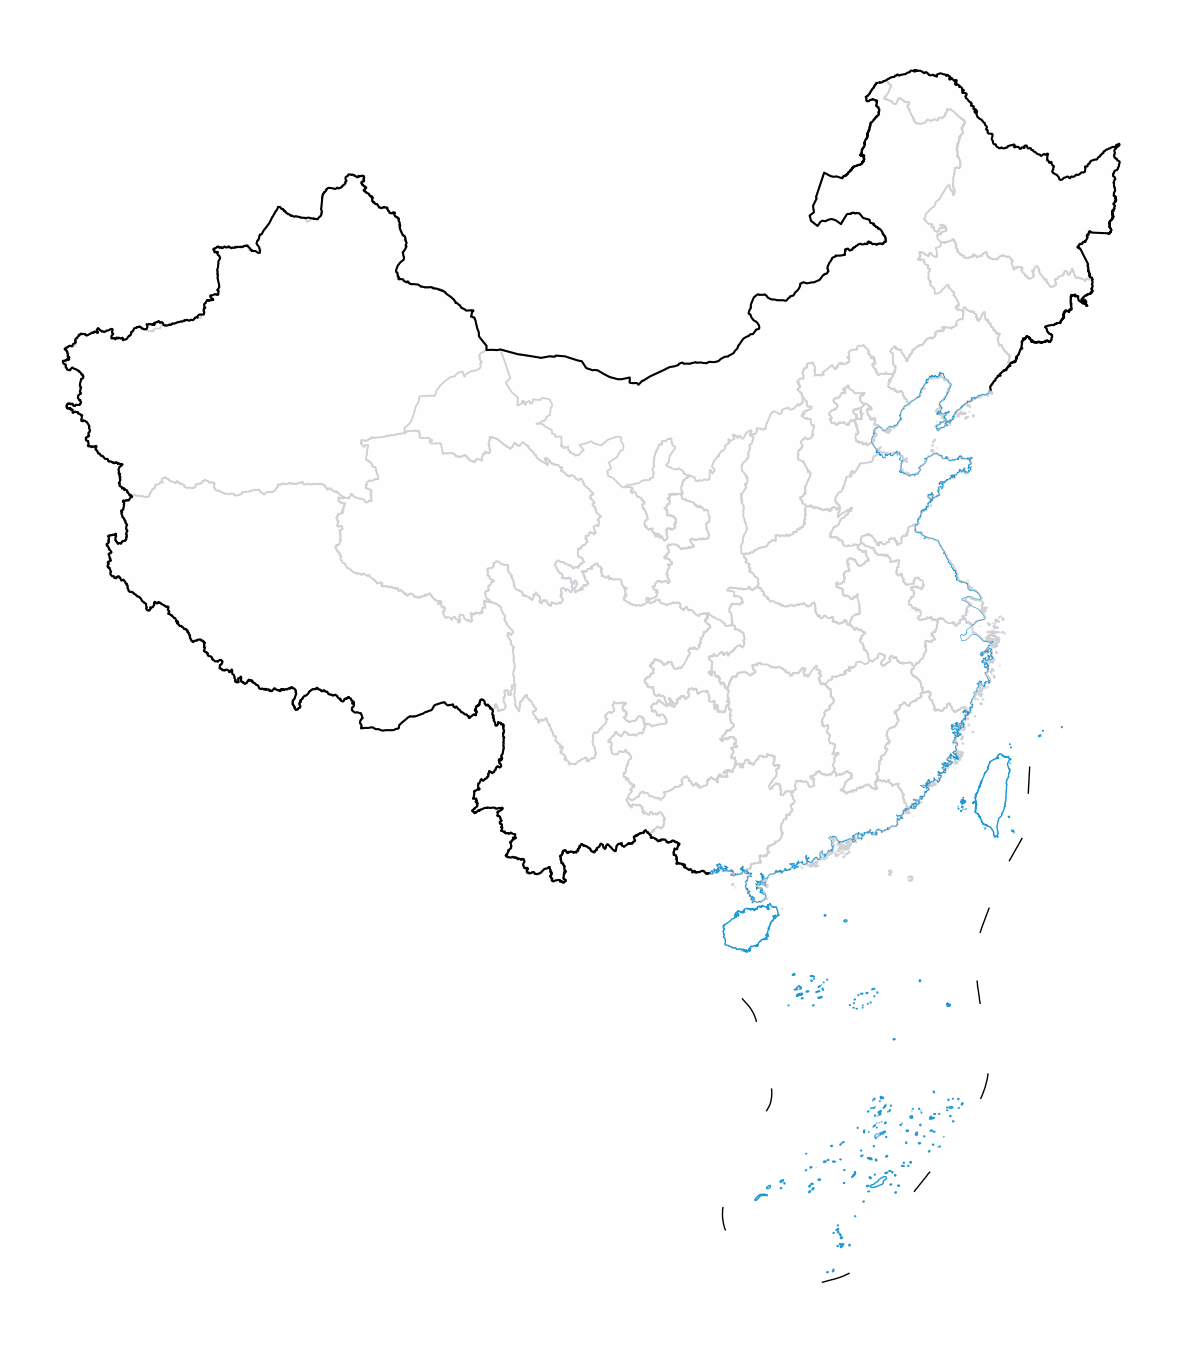

In [16]:
fig, ax = plt.subplots(figsize=(15,18))
ax.axis("off")

# 国家矢量
china_proj1.plot(
    ax=ax,
    color='#fefefe',
    edgecolor='#d0d1d5',
    linewidth=1.2,
    zorder=2
)
nine_lines_proj.plot(
    ax=ax,
    color='#000000',
    linewidth=1,
    zorder=1
)
china_proj2.plot(
    ax=ax,
    color='#fefefe',
    edgecolor='#1d98d5',
    linewidth=1,
    zorder=1
)
coastline_proj.plot(
    ax=ax,
    color='#1d98d5',
    linewidth=0.4,
    zorder=3
)
land_boundary_proj.plot(
    ax=ax,
    color='#000000',
    linewidth=1.5,
    zorder=3
)

plt.savefig("1", dpi=300)
plt.show()

### 加点

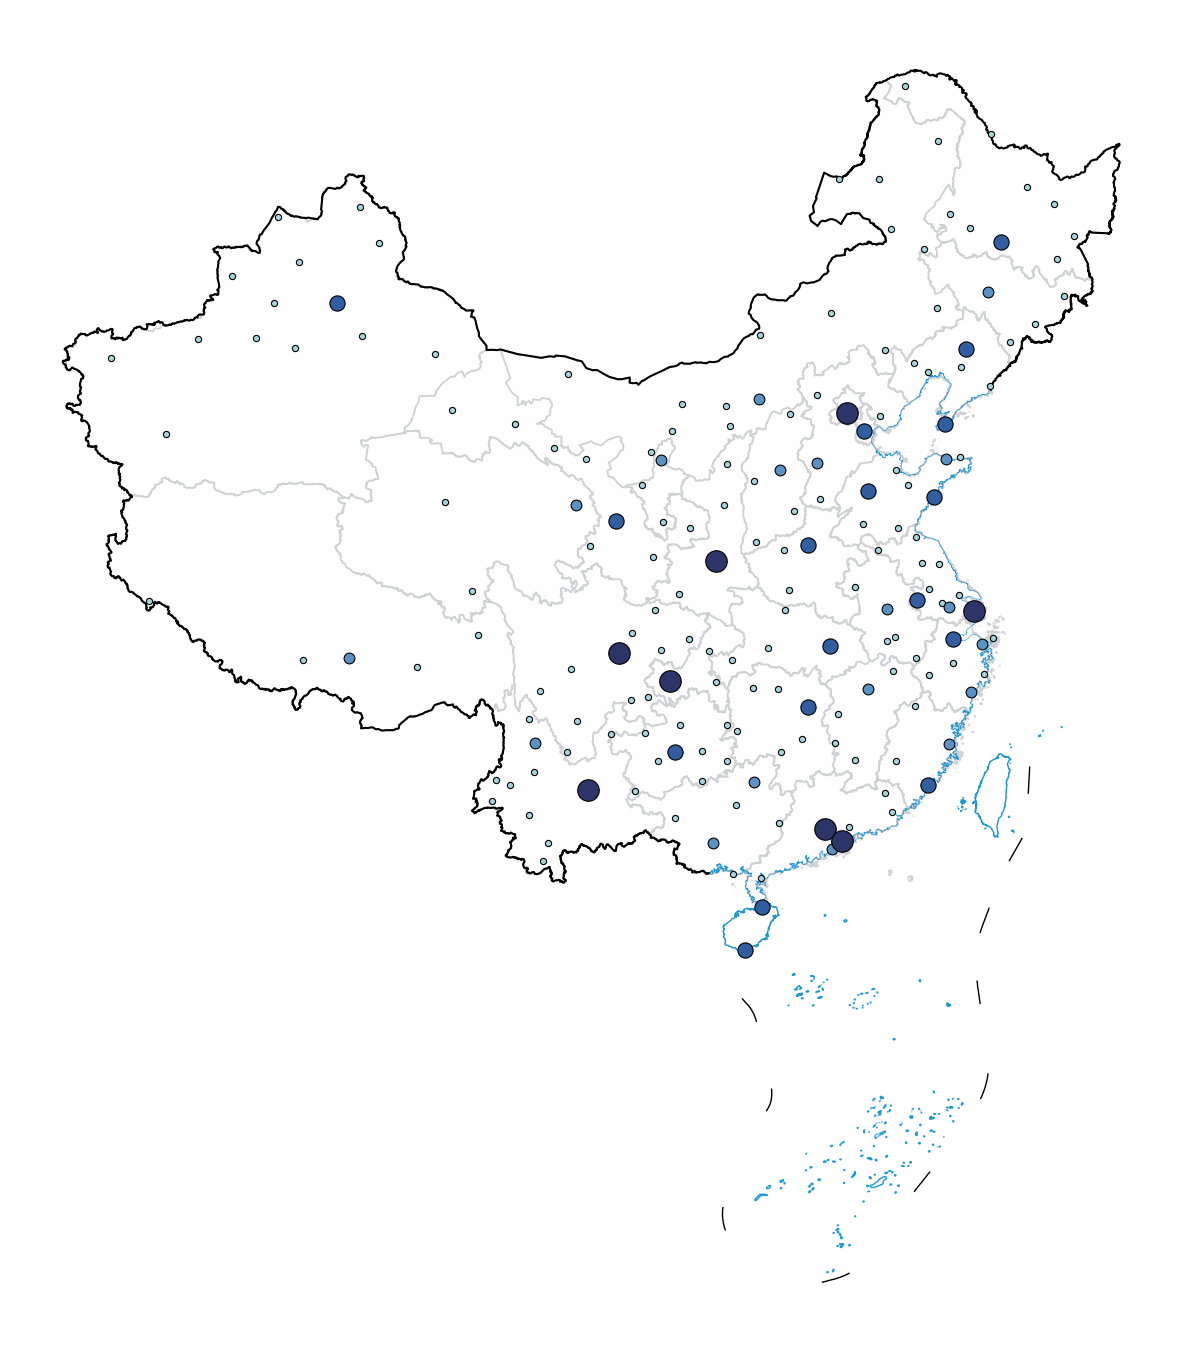

In [17]:
fig, ax = plt.subplots(figsize=(15,18))
ax.axis("off")

# 国家矢量
china_proj1.plot(
    ax=ax,
    color='#fefefe',
    edgecolor='#d0d1d5',
    linewidth=1.2,
    zorder=2
)
nine_lines_proj.plot(
    ax=ax,
    color='#000000',
    linewidth=1,
    zorder=1
)
china_proj2.plot(
    ax=ax,
    color='#fefefe',
    edgecolor='#1d98d5',
    linewidth=1,
    zorder=1
)
coastline_proj.plot(
    ax=ax,
    color='#1d98d5',
    linewidth=0.4,
    zorder=3
)
land_boundary_proj.plot(
    ax=ax,
    color='#000000',
    linewidth=1.5,
    zorder=3
)

# 点
for level, color, size in [
    (0, '#a6d4da', 20),
    (1, '#5992c4', 60),
    (2, '#315da1', 120),
    (3, '#2d3568', 240)
]:
    subset = airports_gdf_proj.query(f'degree_level=={level}')
    ax.scatter(
        subset.geometry.x,
        subset.geometry.y,
        s=size,
        color=color,
        edgecolor='black',
        linewidth=0.8,
        zorder=3
    )

plt.savefig("2", dpi=300)
plt.show()

### 加线

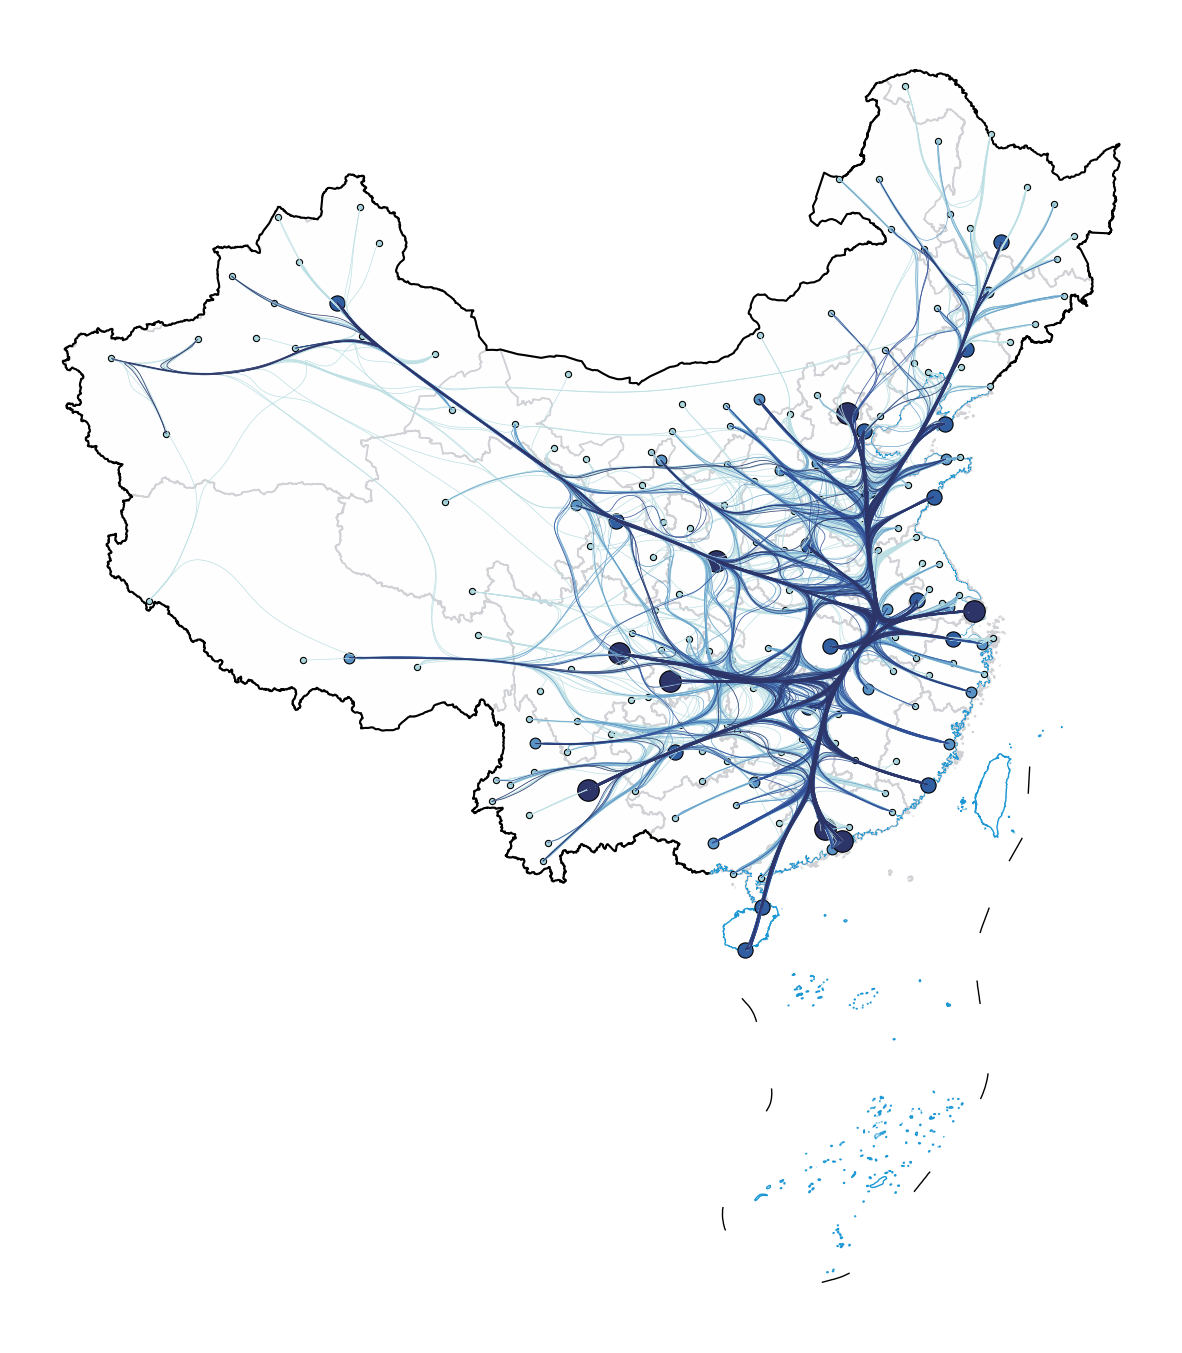

In [18]:
fig, ax = plt.subplots(figsize=(15,18))
ax.axis("off")

# 国家矢量
china_proj1.plot(
    ax=ax,
    color='#fefefe',
    edgecolor='#d0d1d5',
    linewidth=1.2,
    zorder=2
)
nine_lines_proj.plot(
    ax=ax,
    color='#000000',
    linewidth=1,
    zorder=1
)
china_proj2.plot(
    ax=ax,
    color='#fefefe',
    edgecolor='#1d98d5',
    linewidth=1,
    zorder=1
)
coastline_proj.plot(
    ax=ax,
    color='#1d98d5',
    linewidth=0.4,
    zorder=3
)
land_boundary_proj.plot(
    ax=ax,
    color='#000000',
    linewidth=1.5,
    zorder=3
)

# 点
for level, color, size in [
    (0, '#a6d4da', 20),
    (1, '#5992c4', 60),
    (2, '#315da1', 120),
    (3, '#2d3568', 240)
]:
    subset = airports_gdf_proj.query(f'degree_level=={level}')
    ax.scatter(
        subset.geometry.x,
        subset.geometry.y,
        s=size,
        color=color,
        edgecolor='black',
        linewidth=0.8,
        zorder=3
    )

# 线
flow_styles = [
    ('count <= 3', '#bcdfe3', '1~3'),
    ('count > 3 and count <= 7', '#69a3cd', '4~7'),
    ('count > 7 and count <= 14', '#314f97', '8~14'),
    ('count > 14', '#2d3568', '15~45')
]
for cond, color, label in flow_styles:
    bundled_od_gdf_proj.query(cond).plot(
        ax=ax,
        color=color,
        lw=0.5,
        zorder=3,
        label=label
    )

plt.savefig("3", dpi=300)
plt.show()

### 美化边界

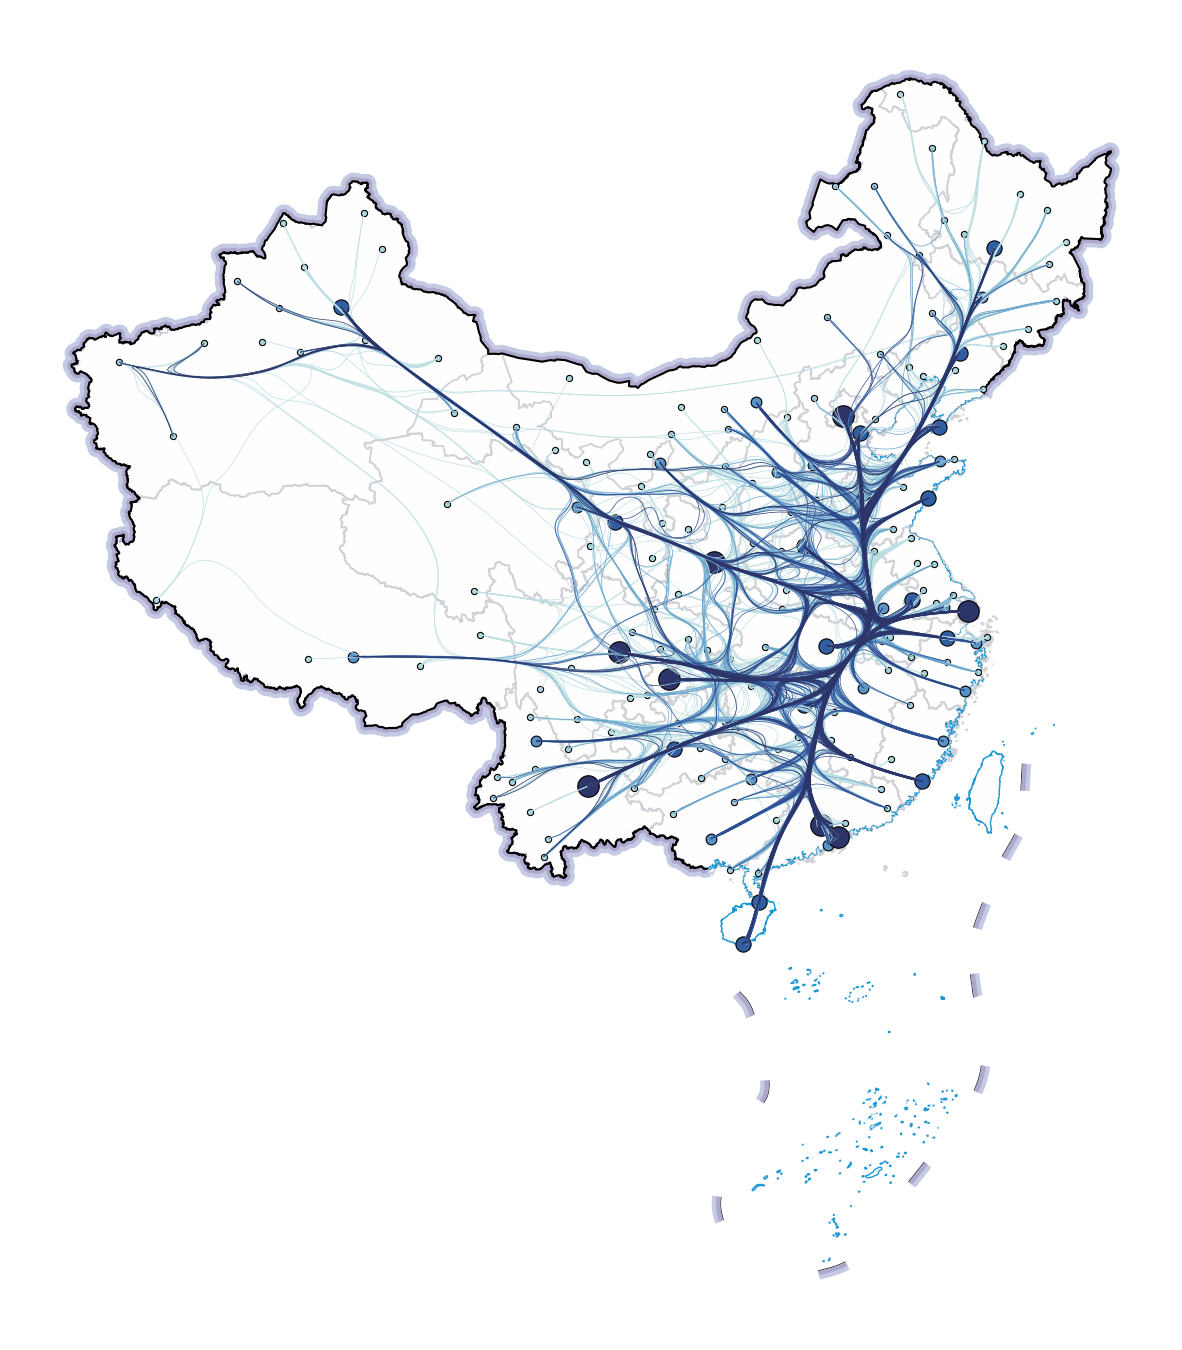

In [19]:
fig, ax = plt.subplots(figsize=(15,18))
ax.axis("off")

# 国家矢量
china_proj1.plot(
    ax=ax,
    color='#fefefe',
    edgecolor='#d0d1d5',
    linewidth=1.2,
    zorder=2
)
nine_lines_proj.plot(
    ax=ax,
    color='#000000',
    linewidth=1,
    zorder=1
)
china_proj2.plot(
    ax=ax,
    color='#fefefe',
    edgecolor='#1d98d5',
    linewidth=1,
    zorder=1
)
coastline_proj.plot(
    ax=ax,
    color='#1d98d5',
    linewidth=0.4,
    zorder=3
)
land_boundary_proj.plot(
    ax=ax,
    color='#000000',
    linewidth=1.5,
    zorder=3
)

# 点
for level, color, size in [
    (0, '#a6d4da', 20),
    (1, '#5992c4', 60),
    (2, '#315da1', 120),
    (3, '#2d3568', 240)
]:
    subset = airports_gdf_proj.query(f'degree_level=={level}')
    ax.scatter(
        subset.geometry.x,
        subset.geometry.y,
        s=size,
        color=color,
        edgecolor='black',
        linewidth=0.8,
        zorder=3
    )

# 线
flow_styles = [
    ('count <= 3', '#bcdfe3', '1~3'),
    ('count > 3 and count <= 7', '#69a3cd', '4~7'),
    ('count > 7 and count <= 14', '#314f97', '8~14'),
    ('count > 14', '#2d3568', '15~45')
]
for cond, color, label in flow_styles:
    bundled_od_gdf_proj.query(cond).plot(
        ax=ax,
        color=color,
        lw=0.5,
        zorder=3,
        label=label
    )

# 美化边界
nine_lines_buffer1_proj.plot(
    ax=ax,
    color='#aea8cd',
    zorder=2
)
nine_lines_buffer2_proj.plot(
    ax=ax,
    color='#c4cae3',
    zorder=1
)
land_boundary_buffer1_proj.plot(
    ax=ax,
    color='#aea8cd',
    zorder=2
)
land_boundary_buffer2_proj.plot(
    ax=ax,
    color='#c4cae3',
    zorder=1
)

plt.savefig("4", dpi=300)
plt.show()

### 加图例

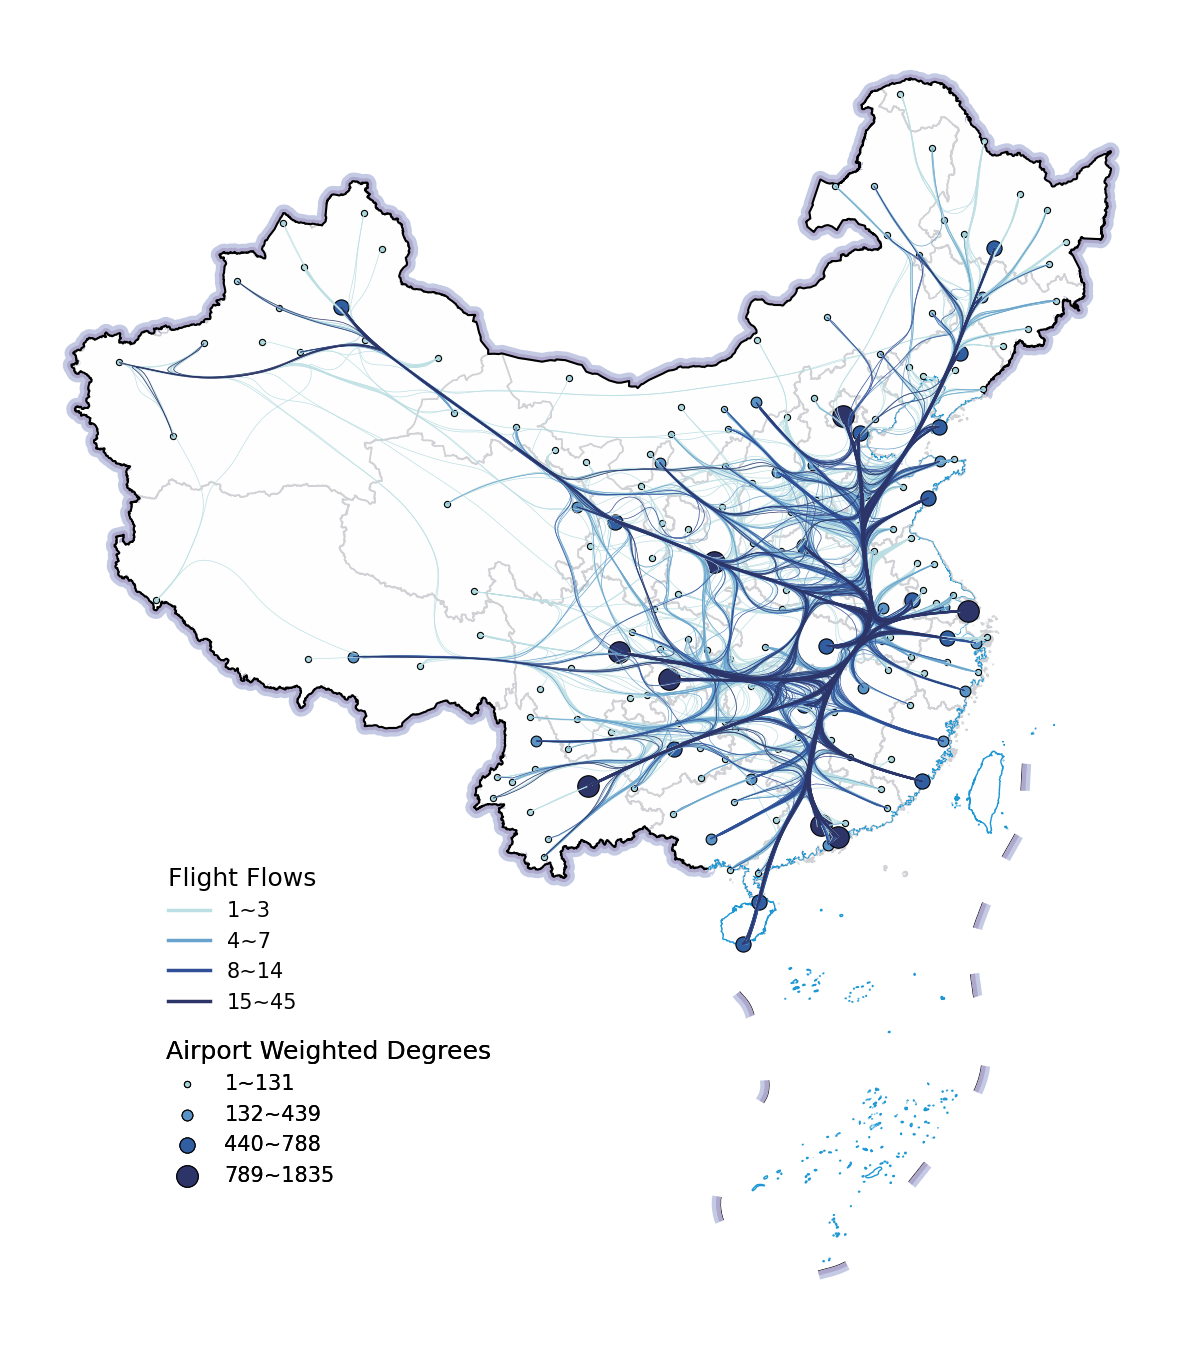

In [20]:
fig, ax = plt.subplots(figsize=(15,18))
ax.axis("off")

# 国家矢量
china_proj1.plot(
    ax=ax,
    color='#fefefe',
    edgecolor='#d0d1d5',
    linewidth=1.2,
    zorder=2
)
nine_lines_proj.plot(
    ax=ax,
    color='#000000',
    linewidth=1,
    zorder=1
)
china_proj2.plot(
    ax=ax,
    color='#fefefe',
    edgecolor='#1d98d5',
    linewidth=1,
    zorder=1
)
coastline_proj.plot(
    ax=ax,
    color='#1d98d5',
    linewidth=0.4,
    zorder=3
)
land_boundary_proj.plot(
    ax=ax,
    color='#000000',
    linewidth=1.5,
    zorder=3
)

# 点
for level, color, size in [
    (0, '#a6d4da', 20),
    (1, '#5992c4', 60),
    (2, '#315da1', 120),
    (3, '#2d3568', 240)
]:
    subset = airports_gdf_proj.query(f'degree_level=={level}')
    ax.scatter(
        subset.geometry.x,
        subset.geometry.y,
        s=size,
        color=color,
        edgecolor='black',
        linewidth=0.8,
        zorder=3
    )

# 线
flow_styles = [
    ('count <= 3', '#bcdfe3', '1~3'),
    ('count > 3 and count <= 7', '#69a3cd', '4~7'),
    ('count > 7 and count <= 14', '#314f97', '8~14'),
    ('count > 14', '#2d3568', '15~45')
]
for cond, color, label in flow_styles:
    bundled_od_gdf_proj.query(cond).plot(
        ax=ax,
        color=color,
        lw=0.5,
        zorder=3,
        label=label
    )

# 美化边界
nine_lines_buffer1_proj.plot(
    ax=ax,
    color='#aea8cd',
    zorder=2
)
nine_lines_buffer2_proj.plot(
    ax=ax,
    color='#c4cae3',
    zorder=1
)
land_boundary_buffer1_proj.plot(
    ax=ax,
    color='#aea8cd',
    zorder=2
)
land_boundary_buffer2_proj.plot(
    ax=ax,
    color='#c4cae3',
    zorder=1
)

# 图例
line_legends = [
    Line2D([0], [0], color='#bcdfe3', lw=2.5, label='1~3'),
    Line2D([0], [0], color='#69a3cd', lw=2.5, label='4~7'),
    Line2D([0], [0], color='#314f97', lw=2.5, label='8~14'),
    Line2D([0], [0], color='#2d3568', lw=2.5, label='15~45')
]
legend_flows = ax.legend(
    handles=line_legends,
    title="Flight Flows",
    bbox_to_anchor=(0.28, 0.37),
    fontsize=15,
    title_fontsize=18,
    frameon=False,
)
ax.add_artist(legend_flows)
legend_flows.get_title().set_ha("left")
legend_flows._legend_box.align = "left"
airport_legends = [
    plt.scatter([], [], s=20, color='#a6d4da', edgecolor='black', lw=0.8, label='1~131'),
    plt.scatter([], [], s=60, color='#5992c4', edgecolor='black', lw=0.8, label='132~439'),
    plt.scatter([], [], s=120, color='#315da1', edgecolor='black', lw=0.8, label='440~788'),
    plt.scatter([], [], s=240, color='#2d3568', edgecolor='black', lw=0.8, label='789~1835')
]
legend_degrees = ax.legend(
    handles=airport_legends,
    title="Airport Weighted Degrees",
    bbox_to_anchor=(0.43, 0.24),
    fontsize=15,
    title_fontsize=18,
    frameon=False
)
ax.add_artist(legend_degrees)
legend_degrees.get_title().set_ha("left")
legend_degrees._legend_box.align = "left"

plt.savefig("5", dpi=300)
plt.show()

### 加指北针/比例尺

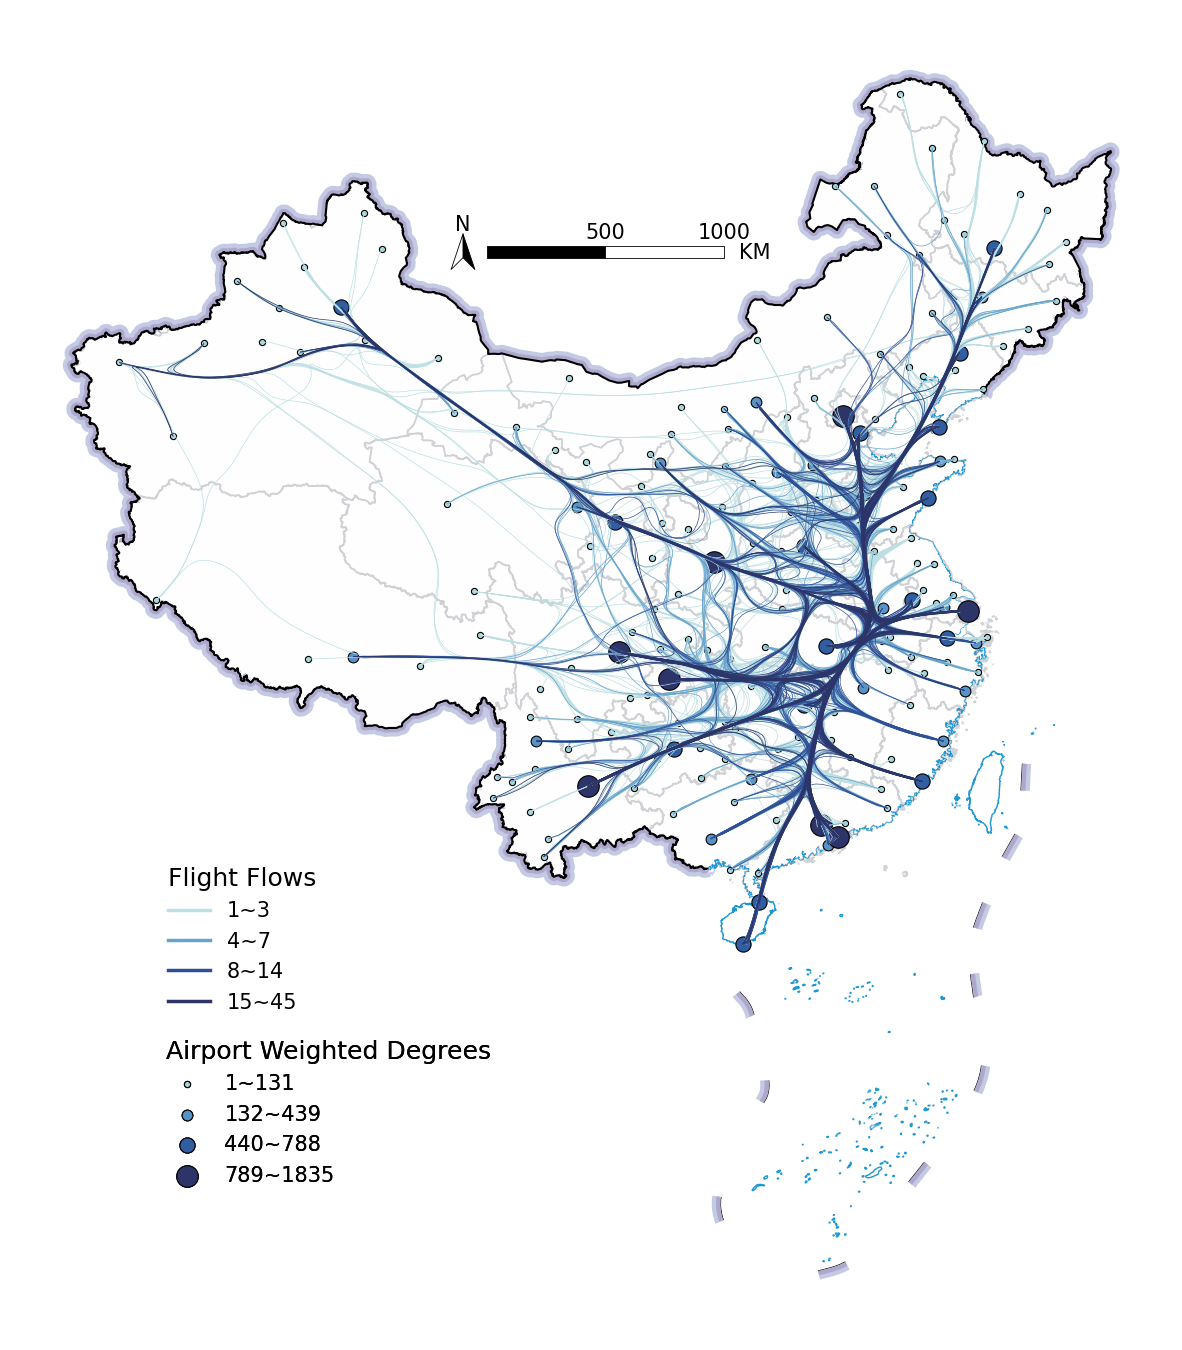

In [21]:
fig, ax = plt.subplots(figsize=(15,18))
ax.axis("off")

# 国家矢量
china_proj1.plot(
    ax=ax,
    color='#fefefe',
    edgecolor='#d0d1d5',
    linewidth=1.2,
    zorder=2
)
nine_lines_proj.plot(
    ax=ax,
    color='#000000',
    linewidth=1,
    zorder=1
)
china_proj2.plot(
    ax=ax,
    color='#fefefe',
    edgecolor='#1d98d5',
    linewidth=1,
    zorder=1
)
coastline_proj.plot(
    ax=ax,
    color='#1d98d5',
    linewidth=0.4,
    zorder=3
)
land_boundary_proj.plot(
    ax=ax,
    color='#000000',
    linewidth=1.5,
    zorder=3
)

# 点
for level, color, size in [
    (0, '#a6d4da', 20),
    (1, '#5992c4', 60),
    (2, '#315da1', 120),
    (3, '#2d3568', 240)
]:
    subset = airports_gdf_proj.query(f'degree_level=={level}')
    ax.scatter(
        subset.geometry.x,
        subset.geometry.y,
        s=size,
        color=color,
        edgecolor='black',
        linewidth=0.8,
        zorder=3
    )

# 线
flow_styles = [
    ('count <= 3', '#bcdfe3', '1~3'),
    ('count > 3 and count <= 7', '#69a3cd', '4~7'),
    ('count > 7 and count <= 14', '#314f97', '8~14'),
    ('count > 14', '#2d3568', '15~45')
]
for cond, color, label in flow_styles:
    bundled_od_gdf_proj.query(cond).plot(
        ax=ax,
        color=color,
        lw=0.5,
        zorder=3,
        label=label
    )

# 美化边界
nine_lines_buffer1_proj.plot(
    ax=ax,
    color='#aea8cd',
    zorder=2
)
nine_lines_buffer2_proj.plot(
    ax=ax,
    color='#c4cae3',
    zorder=1
)
land_boundary_buffer1_proj.plot(
    ax=ax,
    color='#aea8cd',
    zorder=2
)
land_boundary_buffer2_proj.plot(
    ax=ax,
    color='#c4cae3',
    zorder=1
)

# 图例
line_legends = [
    Line2D([0], [0], color='#bcdfe3', lw=2.5, label='1~3'),
    Line2D([0], [0], color='#69a3cd', lw=2.5, label='4~7'),
    Line2D([0], [0], color='#314f97', lw=2.5, label='8~14'),
    Line2D([0], [0], color='#2d3568', lw=2.5, label='15~45')
]
legend_flows = ax.legend(
    handles=line_legends,
    title="Flight Flows",
    bbox_to_anchor=(0.28, 0.37),
    fontsize=15,
    title_fontsize=18,
    frameon=False,
)
ax.add_artist(legend_flows)
legend_flows.get_title().set_ha("left")
legend_flows._legend_box.align = "left"
airport_legends = [
    plt.scatter([], [], s=20, color='#a6d4da', edgecolor='black', lw=0.8, label='1~131'),
    plt.scatter([], [], s=60, color='#5992c4', edgecolor='black', lw=0.8, label='132~439'),
    plt.scatter([], [], s=120, color='#315da1', edgecolor='black', lw=0.8, label='440~788'),
    plt.scatter([], [], s=240, color='#2d3568', edgecolor='black', lw=0.8, label='789~1835')
]
legend_degrees = ax.legend(
    handles=airport_legends,
    title="Airport Weighted Degrees",
    bbox_to_anchor=(0.43, 0.24),
    fontsize=15,
    title_fontsize=18,
    frameon=False
)
ax.add_artist(legend_degrees)
legend_degrees.get_title().set_ha("left")
legend_degrees._legend_box.align = "left"

# 指北针/比例尺
compass_scale_ax = fig.add_axes([0.41, 0.68, 0.2, 0.1], zorder=1)
plotscale(
    compass_scale_ax, 
    bounds=china_proj.total_bounds, 
    textsize=15, 
    compasssize=0.8,
    crs_is_projected=True,
    accuracy=125000,
    style=2
)
compass_scale_ax.axis('off')

plt.savefig('6',dpi=300)
plt.show()

## 裁剪图片

In [22]:
from PIL import Image
import os

In [23]:
from PIL import Image
import os

def crop_image(input_path, output_path, left, top, right, bottom):
    try:
        with Image.open(input_path) as img:
            width, height = img.size
            left = max(0, min(left, width))
            top = max(0, min(top, height))
            right = max(left, min(right, width))
            bottom = max(top, min(bottom, height))
            
            cropped_img = img.crop((left, top, right, bottom))
            
            cropped_img.save(output_path)
            print(f"图片裁剪成功，已保存至: {output_path}")
            return True
    except Exception as e:
        print(f"裁剪图片时出错: {str(e)}")
        return False

In [24]:
pngs = [png for png in os.listdir() if png.endswith('.png')]
pngs

['1.png', '2.png', '3.png', '4.png', '5.png', '6.png']

In [25]:
crop_left = 550
crop_top = 700
crop_right = 4050
crop_bottom = 4800

_ = [crop_image(input_image, input_image.split('.')[0] + '_out.' + input_image.split('.')[1], crop_left, crop_top, crop_right, crop_bottom) for input_image in pngs]

图片裁剪成功，已保存至: 1_out.png
图片裁剪成功，已保存至: 2_out.png
图片裁剪成功，已保存至: 3_out.png
图片裁剪成功，已保存至: 4_out.png
图片裁剪成功，已保存至: 5_out.png
图片裁剪成功，已保存至: 6_out.png
